# Generating Images of Clothes Using Deep Convolutional Generative Adversarial Network (DCGAN)

> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on **GitHub**<br/><br/>
> - ▶️ **Interactive Demo**: [try this model and other machine learning experiments in action](https://trekhleb.github.io/machine-learning-experiments/)

## Experiment overview

In this experiment we will generate images of clothing using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) training loop. For training we will be using Fashion [MNIST dataset](https://www.tensorflow.org/datasets/catalog/fashion_mnist).

A **generative adversarial network** (GAN) is a class of machine learning frameworks. Two neural networks contest with each other in a game. Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look real, while a discriminator ("the art critic") learns to tell real images apart from fakes.

![clothes_generation_dcgan.jpeg](../../demos/src/images/clothes_generation_dcgan.jpeg)

Inspired by: [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan) tutorial.

## Importing dependencies

In [49]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import platform
import imageio
import PIL
import time
import os
import glob
import zipfile

from IPython import display

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


In [50]:
# Checking the eager execution availability.
tf.executing_eagerly()

True

## Loading the data

In [51]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [52]:
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print()
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (60000, 28, 28)
y_train.shape:  (60000,)

x_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


In [53]:
# Since we don't need test examples we may concatenate both sets
x_train = np.concatenate((x_train, x_test), axis=0)

print('x_train.shape: ', x_train.shape)

x_train.shape:  (70000, 28, 28)


In [54]:
TOTAL_EXAMPLES_NUM = x_train.shape[0]

print('TOTAL_EXAMPLES_NUM: ', TOTAL_EXAMPLES_NUM)

TOTAL_EXAMPLES_NUM:  70000


In [57]:
print('y_train[0] =', y_train[0])

y_train[0] = 9


Here are the map of classes for the dataset according to [documentation](https://github.com/zalandoresearch/fashion-mnist):

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

In [58]:
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

## Analyzing the dataset

In [59]:
print(x_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

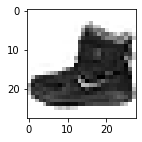

In [60]:
plt.figure(figsize=(2, 2))
plt.imshow(x_train[0], cmap=plt.cm.binary)
plt.show()

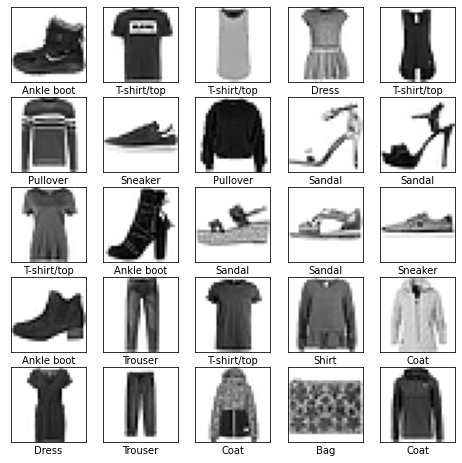

In [11]:
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(8, 8))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

## Reshape and normalize data

In [0]:
x_train_reshaped = x_train.reshape(
    x_train.shape[0],
    x_train.shape[1],
    x_train.shape[2],
    1
).astype('float32')

In [13]:
print('x_train_reshaped.shape: ', x_train_reshaped.shape)

x_train_reshaped.shape:  (70000, 28, 28, 1)


In [0]:
# Normalize image pixel values to [-1, 1] range
x_train_normalized = (x_train_reshaped - 127.5) / 127.5

In [65]:
print('Normalized data values:\n')
print(x_train_normalized[0,:,:,0])

Normalized data values:

[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1. 

## Creating a batched dataset

In [66]:
SHUFFLE_BUFFER_SIZE = TOTAL_EXAMPLES_NUM
BATCH_SIZE = 1024

TRAINING_STEPS_PER_EPOCH = math.ceil(TOTAL_EXAMPLES_NUM / BATCH_SIZE)

print('BATCH_SIZE: ', BATCH_SIZE)
print('TRAINING_STEPS_PER_EPOCH: ', TRAINING_STEPS_PER_EPOCH)

BATCH_SIZE:  1024
TRAINING_STEPS_PER_EPOCH:  69


In [67]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train_normalized) \
    .shuffle(SHUFFLE_BUFFER_SIZE) \
    .batch(BATCH_SIZE)

print(train_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


## Create models

### Create generator

In [68]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    # Step 1.
    model.add(tf.keras.layers.Dense(
        units=7*7*256,
        use_bias=False,
        input_shape=(100,)
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # Step 2.
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # None is a batch size.
    
    # Step 3.
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=128,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        use_bias=False
    ))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # Step 4.
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=64,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        use_bias=False
    ))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # Step 5.
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=1,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        use_bias=False,
        activation='tanh'
    ))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [69]:
generator_model = make_generator_model()

In [70]:
generator_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)        

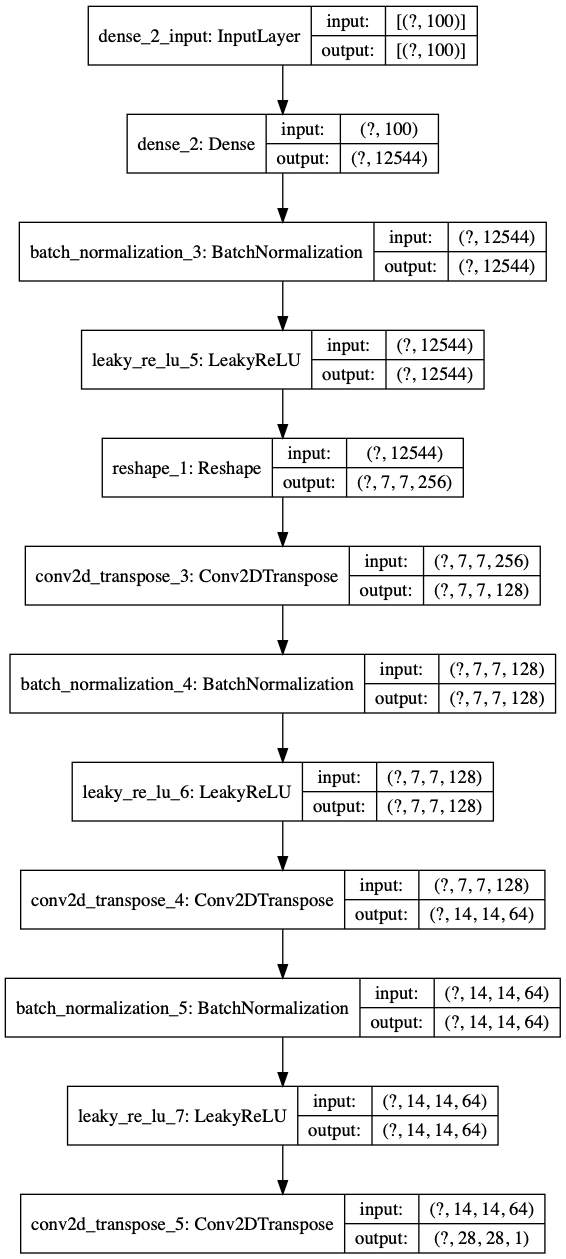

In [71]:
tf.keras.utils.plot_model(
    generator_model,
    show_shapes=True,
    show_layer_names=True,
    to_file='generator_model.png'
)

In [72]:
noise = tf.random.normal(shape=[1, 100])

print(noise.numpy())

[[-0.40048575 -0.05899175  1.4562819  -1.0014365  -0.49212027 -0.02965875
  -0.359166   -0.13207589 -0.05057759 -0.7165569   1.348586   -0.5673278
   1.2634926   0.69921404  0.1937053   0.6227805  -0.8695679   1.5103983
  -0.87547743 -0.9266758  -0.94829696 -0.05095936 -0.33741903  1.7615291
  -0.5133022  -1.9463009  -0.47871232 -0.3488199   0.30957273  0.7816733
  -0.05789489 -0.65704983  1.328389   -0.17778188 -0.09234082  1.3932896
  -0.4493648   1.0459919  -0.27539548 -0.5148557   0.6957658   0.2747286
   1.1346655  -0.58931726  1.2654362  -1.3202895   0.05925234  0.57879525
   0.10334445  0.12310242  0.9459113   0.46510884 -1.7625321   1.1537969
   0.95482457  0.07740594  1.101719   -0.94574606  0.90892     1.0484036
  -1.3593727   0.44116554 -1.3168752  -0.6017726   0.22471838  0.524481
  -0.14121588  0.20263085 -0.29945704  0.7611715   0.42068037  0.25163245
   1.2361112  -0.49910775  0.5315448  -0.29282215  0.44396016  0.18037954
  -0.66255087 -0.01424331  0.25285572  0.5489858

In [73]:
generated_image = generator_model(noise, training=False)

print('generated_image.shape: ', generated_image.shape)

generated_image.shape:  (1, 28, 28, 1)


In [74]:
print(generated_image[0, :, :, 0].numpy())

[[ 3.62146273e-03 -3.37373791e-03 -2.23259837e-03  4.66620969e-03
   1.15258023e-04  5.01324749e-03 -5.11144102e-03 -4.98591131e-03
   3.25806858e-03  3.24650109e-03 -3.68705858e-03 -7.00298278e-03
   7.17507210e-03  3.48935777e-04 -1.13091886e-03 -3.62540688e-03
   4.15722467e-03 -5.91829943e-04  4.71155299e-03 -3.61183868e-03
   3.84368817e-03  5.68057830e-03  5.30142151e-03 -1.17566239e-03
  -1.84537598e-03 -2.84438924e-04 -1.76289608e-03  6.83842576e-04]
 [-2.32459349e-03 -1.27953419e-03 -3.37371975e-03 -1.02897873e-03
  -1.19031165e-02 -3.47901043e-03  1.06568029e-02  1.61387771e-02
  -1.69485938e-02  1.10559864e-03 -1.05018653e-02  5.57437493e-03
   2.92407884e-03 -4.07211157e-03  5.88989642e-04  2.27185269e-03
   1.62952056e-03  9.98135749e-03  6.50358619e-03  5.50584961e-03
  -3.35985026e-03  5.92968427e-03  8.01353902e-03  1.04573760e-02
  -5.20926062e-03 -3.15492740e-03 -9.45294369e-03 -2.02907156e-03]
 [-1.08655437e-03 -9.76242532e-04  1.22154327e-02  2.89549213e-03
  -2.402

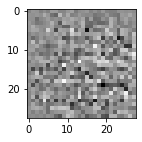

In [75]:
plt.figure(figsize=(2, 2))
plt.imshow(generated_image[0, :, :, 0], cmap=plt.cm.binary)

### Create discriminator

The model will be trained to output positive values for real images, and negative values for fake images.

In [76]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    # Step 1.
    model.add(tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        input_shape=[28, 28, 1]
    ))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Step 2.
    model.add(tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same'
    ))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Step 3.
    model.add(tf.keras.layers.Flatten())
    
    # Real vs Fake
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [78]:
discriminator_model = make_discriminator_model()

In [79]:
discriminator_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

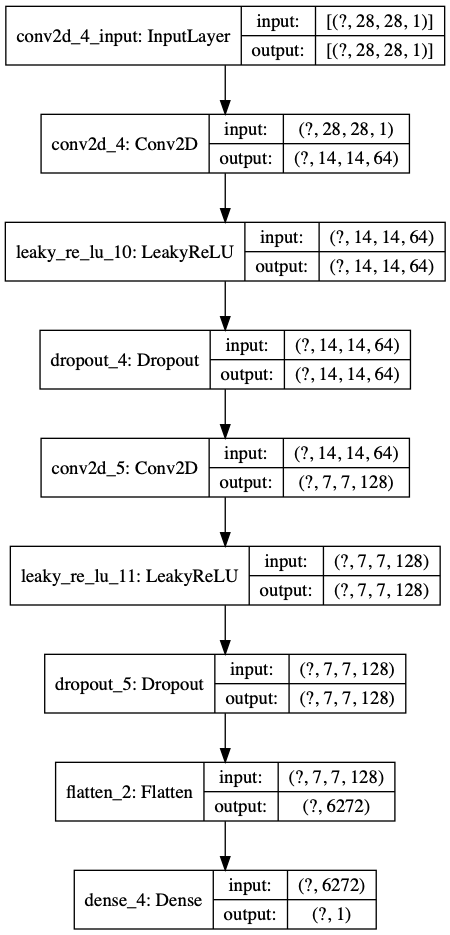

In [80]:
tf.keras.utils.plot_model(
    discriminator_model,
    show_shapes=True,
    show_layer_names=True,
    to_file='discriminator_model.png'
)

In [81]:
dicision = discriminator_model(generated_image)

print(dicision)

tf.Tensor([[0.00100495]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [82]:
def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    
    return total_loss

In [83]:
# Test discriminator loss function.
output_combinations = [
     # REAL  #FAKE
    ([-1.],  [1.]),
    ([1.],   [-1.]),  
    ([1.],   [0.]),
    ([10.],  [-1.]),                       
]
for (real_output, fake_output) in output_combinations:
    loss = discriminator_loss(real_output, fake_output).numpy()
    print('Discriminator loss for:', real_output, fake_output)
    print('  REAL output:', real_output)
    print('  FAKE output:', fake_output)
    print('  loss: ', loss)
    print()

Discriminator loss for: [-1.0] [1.0]
  REAL output: [-1.0]
  FAKE output: [1.0]
  loss:  2.6265235

Discriminator loss for: [1.0] [-1.0]
  REAL output: [1.0]
  FAKE output: [-1.0]
  loss:  0.6265234

Discriminator loss for: [1.0] [0.0]
  REAL output: [1.0]
  FAKE output: [0.0]
  loss:  1.0064089

Discriminator loss for: [10.0] [-1.0]
  REAL output: [10.0]
  FAKE output: [-1.0]
  loss:  0.31330708



### Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [84]:
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

In [85]:
# Test generator loss function.
print('Generator loss for >1: ', generator_loss([5.]).numpy())
print('Generator loss for =0: ', generator_loss([0.]).numpy())

Generator loss for >1:  0.0067153485
Generator loss for =0:  0.6931472


### Optimizers

In [86]:
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)

discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)

### Checkpoints

In [0]:
checkpoint_dir = './tmp/ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator_model=generator_model,
    discriminator_model=discriminator_model
)

## Training

In [0]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
input_noise_seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [87]:
# This `tf.function` annotation causes the function to be "compiled".
# @tf.function
def train_step(real_images):
    training_history = {
        'discriminator': {
            'loss': None
        },
        'generator': {
            'loss': None
        }
    }

    # Generate input noise.
    noise_images = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images.
        generated_images = generator_model(
            noise_images,
            training=True
        )
        
        # Detect fake and real images.
        real_output = discriminator_model(
            real_images,
            training=True
        )
        fake_output = discriminator_model(
            generated_images,
            training=True
        )
        
        # Calculate losses.
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(
            real_output,
            fake_output
        )

        training_history['discriminator']['loss'] = disc_loss.numpy()
        training_history['generator']['loss'] = gen_loss.numpy()
    
    # Calculate gradients.
    gradients_of_generator = gen_tape.gradient(
        gen_loss,
        generator_model.trainable_variables
    )
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss,
        discriminator_model.trainable_variables
    )
    
    # Do gradient step.
    generator_optimizer.apply_gradients(zip(
        gradients_of_generator,
        generator_model.trainable_variables
    ))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator_model.trainable_variables
    ))

    return training_history

In [88]:
def train(dataset, epochs, start_epoch=0):
    print('Start training...')
    
    training_history = {
        'discriminator': {
            'loss': []
        },
        'generator': {
            'loss': []
        }
    }

    for epoch in range(epochs)[start_epoch:]:
        print('Start epoch #{} ({} steps)...'.format(epoch + 1, TRAINING_STEPS_PER_EPOCH))
        
        start = time.time()
        
        step = 0
        for image_batch in dataset:
            step += 1
            
            # display.clear_output(wait=True)
            # show_progress(step, TRAINING_STEPS_PER_EPOCH)
            # generate_and_save_images(
            #     generator_model,
            #     epoch + 1,
            #     input_noise_seed,
            #     save=False
            # )
            
            training_step_history = train_step(image_batch)

            discriminator_step_loss = training_step_history['discriminator']['loss']
            generator_step_loss = training_step_history['generator']['loss']

        training_history['discriminator']['loss'].append(discriminator_step_loss)
        training_history['generator']['loss'].append(generator_step_loss)
            
        # Produce images for the GIF as we go.
        display.clear_output(wait=True)
        generate_and_save_images(
            generator_model,
            epoch + 1,
            input_noise_seed
        )
        
        # Save the model every 10 epochs.
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print('Time for epoch #{} is {:.2f}s'.format(epoch + 1, time.time() - start))
        print('Discriminator loss: {:.4f}'.format(discriminator_step_loss))
        print('Generator loss: {:.4f}'.format(generator_step_loss))

    return training_history

In [89]:
def show_progress(current_step, total_steps):
    length_divider = 2
    progress = math.floor(current_step * 100 / total_steps)
    done_steps = progress
    left_steps = 100 - done_steps
    done_dots = ''.join(['◼︎' for step in range(math.floor(done_steps / length_divider))])
    left_dors = ''.join(['・' for step in range(math.floor(left_steps / length_divider))])
    print(f'{current_step}/{total_steps}: {done_dots}{left_dors}')

In [90]:
# Test progress function.
show_progress(15, 68)

15/68: ◼︎◼︎◼︎◼︎◼︎◼︎◼︎◼︎◼︎◼︎◼︎・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・


In [91]:
IMAGES_PREVIEW_PATH = 'tmp/imgs/'

if not os.path.exists(IMAGES_PREVIEW_PATH):
    os.makedirs(IMAGES_PREVIEW_PATH)

In [92]:
def generate_and_save_images(model, epoch, test_input, save=True):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    
    fig_dimension = int(math.sqrt(num_examples_to_generate))
    plt.figure(figsize=(8, 8))
    fig = plt.figure(figsize=(fig_dimension, fig_dimension))
    
    for i in range(predictions.shape[0]):
        plt.subplot(fig_dimension, fig_dimension, i+1)
        plt.imshow(
            predictions[i, :, :, 0] * 127.5 + 127.5,
            cmap=plt.cm.binary
        )
        plt.axis('off')
        
    if save:
        plt.savefig('{}image_at_epoch_{:04d}.png'.format(IMAGES_PREVIEW_PATH, epoch))
        
    plt.show()

In [93]:
if not 'training_history' in locals():
    training_history = {
        'discriminator': {
            'loss': []
        },
        'generator': {
            'loss': []
        }
    }

In [0]:
training_session_num = 1
start_epoch = training_session_num * EPOCHS
epochs_num = start_epoch + EPOCHS

<Figure size 576x576 with 0 Axes>

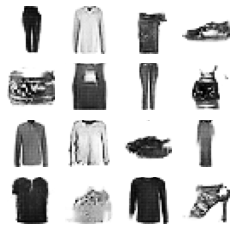

Time for epoch #2700 is 10.57s
Discriminator loss: 1.2439
Generator loss: 0.9003


In [168]:
training_history_current = train(
    train_dataset,
    epochs=epochs_num,
    start_epoch=start_epoch
)

## Analyzing training history

In [0]:
training_history['generator']['loss'] += training_history_current['generator']['loss']
training_history['discriminator']['loss'] += training_history_current['discriminator']['loss']

In [0]:
def render_training_history(training_history):
    generator_loss = training_history['generator']['loss']
    discriminator_loss = training_history['discriminator']['loss']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(generator_loss, label='Generator loss')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(discriminator_loss, label='Discriminator loss')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

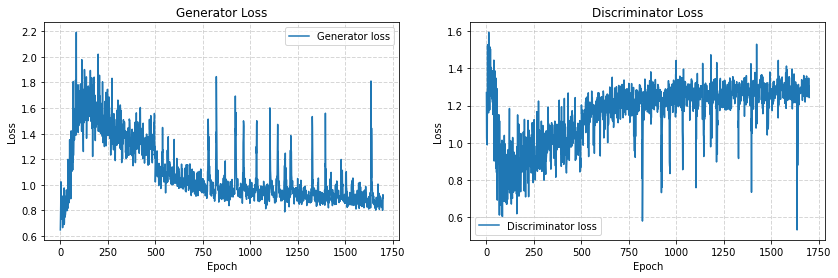

In [170]:
render_training_history(training_history)

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Save models

In [0]:
generator_model.save('generator_model.h5', save_format='h5')
discriminator_model.save('discriminator_model.h5', save_format='h5')

In [107]:
# Restore models from files if needed.
# generator_model.load_weights('./generator_model.h5')
# discriminator_model.load_weights('./discriminator_model.h5')

## Zip all preview images

In [96]:
def zip_image_previews():
    images_previews_path = IMAGES_PREVIEW_PATH
    images_previews_zip_name = 'images_previews.zip'

    zipped_files_num = 0
    with zipfile.ZipFile(images_previews_zip_name, mode='w') as zip_obj:
        for folder_name, subfolders, filenames in os.walk(images_previews_path):
            for filename in filenames:
                zipped_files_num += 1
                file_path = os.path.join(folder_name, filename)
                zip_obj.write(file_path, os.path.basename(file_path))
    print('Zipped {} files to '.format(zipped_files_num), images_previews_zip_name)

In [178]:
zip_image_previews()

Zipped 2600 files to  images_previews.zip


## Trying models

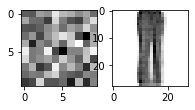

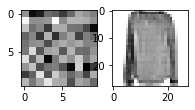

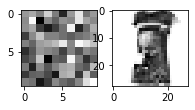

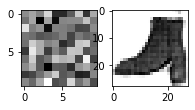

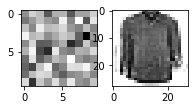

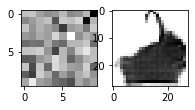

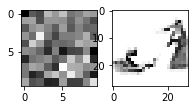

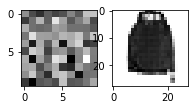

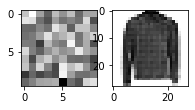

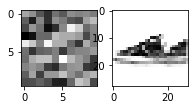

In [118]:
test_examples_num = 10

noise_images = tf.random.normal([test_examples_num, 100])
generated_images = generator_model(noise_images, training=False)

for example_num in range(test_examples_num):
    plt.figure(figsize=(3, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(noise_images[example_num], (10, 10)), cmap=plt.cm.binary)

    plt.subplot(1, 2, 2)
    plt.imshow(generated_images[example_num, :, :, 0], cmap=plt.cm.binary)

## Create a GIF

In [97]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('{}image_at_epoch_{:04d}.png'.format(IMAGES_PREVIEW_PATH, epoch_no))

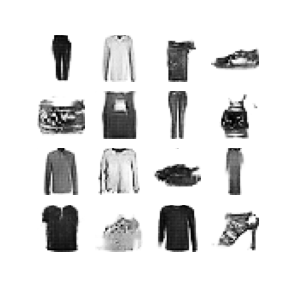

In [99]:
display_image(EPOCHS)

In [0]:
anim_file = 'clothes_generation_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(IMAGES_PREVIEW_PATH + 'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
    image = imageio.imread(filename)
    writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)